In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from peakdetect.utils.dataset import DPdataset
from peakdetect.utils.dataset_no_simulation import DPdataset_no_simulation

cif = 'simulation_data/Acetaminophen_orthorhombic.cif'
euler_angles = 'simulation_data/anglefile_Acetaminophen_orthorhombic_5_degree.txt'
save_path_dp_image='simulation_data/Acetaminophen_orthorhombic_5_degree_dp_images'

dp_dataset = DPdataset(cif, euler_angles, pattern_size=128, reciprocal_radius=0.5, minimum_intensity=0.05)


In [6]:
dp_dataset.create_datasets(save_folder_path='simulation_data/train_valid_data', data_name='Acetaminophen_orthorhombic_5_degree', test_size=0.05)

Preparing class data ...
Class data done!
Preparing training data ...
Training data done!
Preparing validation data ...
Training data done!


In [2]:
from peakdetect.utils.dataset import DPdataset
from peakdetect.utils.dataset_no_simulation import DPdataset_no_simulation

dp_dataset_no_simulation = DPdataset_no_simulation(struct_filename='simulation_data/Acetaminophen_orthorhombic.cif', 
                                                   euler_angle_filename='simulation_data/train_valid_data/Acetaminophen_orthorhombic_5_degree_euler_angles_train.csv',
                                                   dp_image_path='simulation_data/train_valid_data/Acetaminophen_orthorhombic_5_degree_dp_images_train',
                                                   targets_path='simulation_data/train_valid_data/Acetaminophen_orthorhombic_5_degree_targets_train',
                                                   pattern_size=128, 
                                                   reciprocal_radius=0.5)

In [2]:
from peakdetect.data_module import DPDataModule
from peakdetect.lightning_module import EDPeakDector
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

args = dict(model='peakdetect/peakdetect_Resnet.cfg',
            data = 'peakdetect/data.cfg',
            checkpoint_path='checkpoints/orth_5_degree',
            model_name='orth_5_degree_Resnet',
            version='test',
            test_data_ratio=0.05,
            batch_size=16,
            precision_for_training=16,
            num_epoch=30,
            verbose='store_true',
            n_cpu=4,
            iou_thres=0.5,
            conf_thres=0.1,
            nms_thres=0.5,
            seed=0)

# Set Logger
logger = TensorBoardLogger(save_dir="lightning_logs",
                           name=args['model_name'],
                           version=args['version'])

# Set checkpoints paths
checkpoint_callback = ModelCheckpoint(
    save_top_k=5,
    monitor="precision",
    every_n_epochs=5,
    mode="max",
    dirpath=args['checkpoint_path'],
    filename= args['model_name'] + "-{epoch:02d}-{precission:.2f}",
)

In [7]:
model = EDPeakDector(args)
data_module = DPDataModule(args, simulation=False)
trainer = pl.Trainer(max_epochs=args['num_epoch'], 
                     callbacks=[TQDMProgressBar(refresh_rate=20),checkpoint_callback],
                     logger=logger,
                     precision=args['precision_for_training'],
                     accelerator='gpu', 
                     devices=[0,1,2,3],
                     strategy='dp')

trainer.fit(model, data_module)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type    | Params
----------------------------------
0 | model | Darknet | 24.0 M
----------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
47.913    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
PATH='checkpoints/orth_5_degree_Resnet/orth_5_degree_Resnet-epoch=144-precission=0.00.ckpt'
model = EDPeakDector.load_from_checkpoint(checkpoint_path=PATH,args=args)
model.eval()

data_module = DPDataModule(args, simulation=False)
data_module.prepare_data()
data_module.setup(stage='fit')

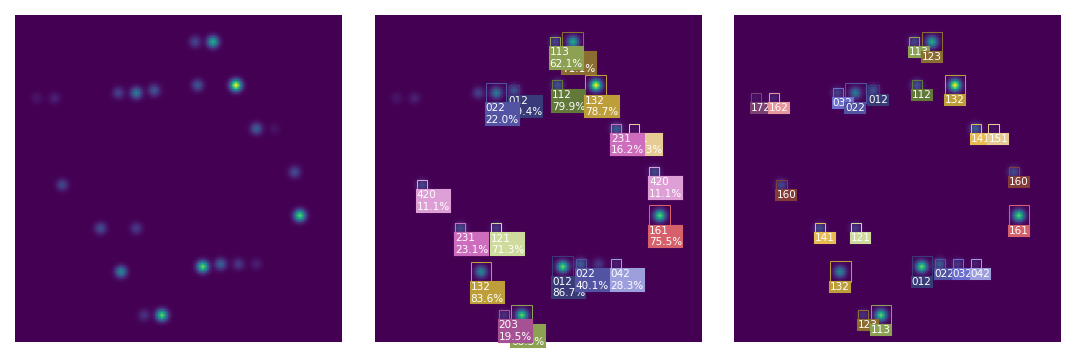

In [9]:
img, targets,_,_=data_module.valid.__getitem__(159)
model.detect_sigle_dp(img, targets)

In [2]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13945), started 0:00:05 ago. (Use '!kill 13945' to kill it.)

In [ ]:
import hydra
from hydra.core.config_store import ConfigStore
from peakdetect.config import PeakConfig

cs = ConfigStore.instance()
cs.store(name="peak_config", node=PeakConfig)

@hydra.main(config_path='conf', config_name='config.yaml')
def main(cfg:PeakConfig):
    print(cfg)

main()

In [9]:
from peakdetect.utils.utils import xywh2xyxy, non_max_suppression
import torch
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

def detect_sigle_dp(classes, img, model, targets):
    model.eval().cuda()

    img = img.unsqueeze(0).to(device='cuda', dtype=torch.float)
    outputs = model(img)
    outputs = non_max_suppression(outputs, conf_thres=model.args['conf_thres'], iou_thres=model.args['iou_thres'])

    targets[:, 2:] = xywh2xyxy(targets[:, 2:])
    targets[:, 2:] *= img.size(3)
    targets = targets.cpu()

    detections_pred = outputs[0].cpu()
    detections_target = targets.cpu()
    num_detections_target = detections_target.size(0)
    detections_target = torch.cat((detections_target, torch.ones(num_detections_target,1)),axis=1)
    detections_target = detections_target[:,[2,3,4,5,6,1]]

    # colors
    unique_labels = torch.cat((detections_pred,detections_target),axis=0)[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)

    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    bbox_colors = colors #random.sample(colors, n_cls_preds)

    fig, axs = plt.subplots(1,3, figsize=(9,3), dpi=150)
    for i in range(3):
        if i==0:
            axs[i].imshow(img.squeeze().cpu().detach().numpy())

        else:
            # model prediction
            if i==1:
                axs[i].imshow(img.squeeze().cpu().detach().numpy())
                detections = detections_pred.to("cpu")

            # ground truth
            elif i==2:
                axs[i].imshow(img.squeeze().cpu().detach().numpy())
                detections = detections_target.cpu()


            for x1, y1, x2, y2, conf, cls_pred in detections:

                box_w = x2 - x1
                box_h = y2 - y1

                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=0.5, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                axs[i].add_patch(bbox)
                # Add label
                if i==2:
                    axs[i].text(
                        x1,#-0.5*box_w,
                        y2,
                        fontsize=5,
                        s=classes[int(cls_pred)],
                        color="white",
                        verticalalignment="top",
                        horizontalalignment="left",
                        bbox={"color": color, "pad": 0})
                if i==1:
                    axs[i].text(
                        x1,#,
                        y2,
                        fontsize=5,
                        s=classes[int(cls_pred)]+f'\n{conf*100:.1f}%',
                        color="white",
                        verticalalignment="top",
                        horizontalalignment="left",
                        bbox={"color": color, "pad": 0})

        axs[i].axis("off")
        axs[i].xaxis.set_major_locator(NullLocator())
        axs[i].yaxis.set_major_locator(NullLocator())

    fig.subplots_adjust(wspace=0.1, hspace=0.00)
    plt.show()

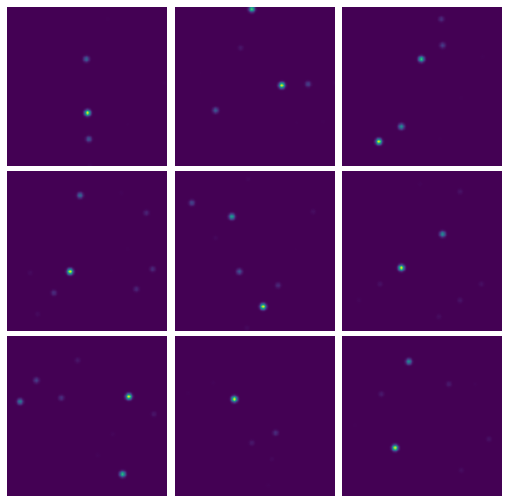

In [76]:
fig, axs = plt.subplots(3,3,figsize=(9,9))
for i in range(3):
    for j in range(3):
        img, _,_,_=data_module.valid.__getitem__(i+3*j)
        axs[i,j].imshow(img.cpu().numpy().squeeze())
        axs[i,j].axis("off")

fig.subplots_adjust(wspace=0.0, hspace=0.03)

In [3]:
model.model[]

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff